In [ ]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt

from pathlib import Path
import pathlib
import shutil

from matplotlib import pyplot as plt
from IPython.display import clear_output
import numpy as np
import tensorflow as tf
import re
import sys
import os
from sklearn.model_selection import train_test_split
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

In [ ]:
def preprocess_y(y_df, window_size, y_label_jump, shift ):
    y_vals = y_df.copy()
    col_names = y_vals.columns.values
    y_vals_trunc_arr = []
    
    for r in range(window_size+y_label_jump-1, len(y_vals), shift):
        y_vals_trunc_arr.append(y_vals.iloc[r][col_names].values[0])
    y_vals_preprocessed = pd.DataFrame(data=y_vals_trunc_arr,  columns=col_names)
    return y_vals_preprocessed

def windowed_dataset(x_df, y_df, window_size, batch_size, shuffle_buffer, shift):
    dataset = tf.data.Dataset.from_tensor_slices(x_df)
    dataset = dataset.window(window_size, shift=shift, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size))


    dataset_y = tf.data.Dataset.from_tensor_slices(y_df)
    dataset_y = dataset_y.window(1, shift=1, drop_remainder=True)
    dataset_y = dataset_y.flat_map(lambda window: window.batch(1))

    dataset = tf.data.Dataset.zip((dataset, dataset_y))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset


def get_window_data_batch_shape(windowed, columns_x, column_y):
    for x,y in windowed:
        print(len(x), '  per batch (', batch_size, ')') 
        print(len(y), '  per batch (', batch_size, ')') 

        print(len(x[0]), ' x length of 1 array in batch (', window_size, ')')#
        print(len(y[0]), ' y length of 1 array in batch (1)')#

        print(len(x[0][0]), ' x values per instance  (', len(columns_x), ')' )

        print(len(y[0][0]), ' y values per instance  (', len(column_y), ')' )
    break

## TESTING the windowed_dataset

In [ ]:

csvs = glob.glob('../data/sahc_csv/*')

temp = pd.read_csv(csvs[7])
temp.dropna(how= 'any', inplace=True)
temp['G-force_z_axis'].max()

In [ ]:
window_size = 3000
shift = 1000
jump = 3000
batch_size = 50000
shuffle_buffer = 1000

columns_x = [ 'min' 'electrocardiogram_signal',
                    'noininvasible_blood_pressure',
                    'G-force_z_axis', 'blood_pressure_systolic_value']
column_y =[ 'blood_pressure_systolic_value']

y_df = preprocess_y(temp[column_y], window_size, jump,shift)
windowed = windowed_dataset(temp[columns_x], y_df, window_size, 50000, shuffle_buffer, shift)

In [ ]:
get_window_data_batch_shape(windowed)

2339   per batch ( 50000 )
2339   per batch ( 50000 )
3000  x length of 1 array in batch ( 3000 )
1  y length of 1 array in batch (1)
4  x values per instance  ( 4 )
1  y values per instance  ( 1 )


## End of testing

In [ ]:
# Default Parameters
window_size = 3000
shift = 1000
jump = 3000
batch_size = 100
shuffle_buffer = 10

In [ ]:
## Helper function to fetch 1 run and check if the file is valid
#################################################################
root_path = ""
def fetch_validate_file(path):

  
  is_valid = True
  err_message = ""
  run = pd.read_csv(path)

  # dismiss invalid subject
  if run['subject'].values[0] == '0AA':
    err_message = "Invalid Subject : 0AA"
    is_valid = False

  # dismiss when data has no min column
  if 'min' in run.columns:
    run = run.sort_values(by=['min'])
    run.reset_index(inplace=True)
  else:
      is_valid = False
      err_message = "Data has no valid time column (min)"

  # dismiss if g-force is less than 0.75
  run.dropna(how= 'any', inplace=True)
  max_g_force = round(run['G-force_z_axis'].max(), 2)
  if max_g_force < 0.75:
    err_message = "The maximum G Force z axis is < 0.75"
    is_valid = False

  return run, {"valid": is_valid, "message":err_message, 'file_name': path}

def get_valid_invalid_runs(csvs, verbose=0): #0 no comments, 1 overall comments, and 2 detailed comments
  invalid_runs_path = '{}data/invalid_runs_reason.csv'.format(root_path)
  dismissed_runs = []

  # check if we already saved the list of invalid runs
  if os.path.isfile(invalid_runs_path) and \
   'file_name' in pd.read_csv(invalid_runs_path).columns:
    dismissed_runs = pd.read_csv(invalid_runs_path)['file_name'].values.tolist()

    
  else:  
    if verbose  ==1 : print('fetching invalid files')
    invalidation_reasons = []

    for csv in csvs:
      if verbose  ==2 : print(csv)
      
      _, validity = fetch_validate_file(csv)
      
      if not validity['valid']:
        invalidation_reasons.append(validity)
        if verbose ==2: print('invalid file: ', validity['message'])
        dismissed_runs.append(csv)
    if verbose in (1,2):
      print('saving the invalid runs reasons as csv in: data/invalid_runs_reason.csv')
    pd.DataFrame(invalidation_reasons).to_csv('{}data/invalid_runs_reason.csv'.format(root_path))

  valid_runs = [f for f in csvs if f not in dismissed_runs]   
    
  if verbose in (1,2): 
     print('there are ', len(valid_runs), ' valid runs')
      

  

  return dismissed_runs, valid_runs

# main function to get all the data
###################################
def get_all_windowed_data():


  csvs = glob.glob('{}data/sahc_csv/*'.format(root_path))

  columns_x = [ 'min', 'electrocardiogram_signal',
                    'noininvasible_blood_pressure',
                    'G-force_z_axis', 'blood_pressure_systolic_value']
  column_y =[ 'blood_pressure_systolic_value']


  # CHECK VALID CSVS
  _, valid_runs = get_valid_invalid_runs(csvs, verbose=1)

  # get train and test sets
  train_size = round(len(valid_runs)*0.8)
  print('we have {} training runs out of {}'.format(str(train_size), str(len(valid_runs))))
  counter_run = 0
  dataset_train = None
  dataset_test = None

  for csv in valid_runs:

    run, _ = fetch_validate_file(csv)
    
    y_df = preprocess_y(run[column_y], window_size, jump,shift)
    windowed = windowed_dataset(run[columns_x], y_df, window_size, batch_size, shuffle_buffer, shift)
    # split to train test
    counter_run = counter_run +1
    if counter_run >= train_size:
      if dataset_test == None: dataset_test = windowed
      else: dataset_test.concatenate(windowed)
    else:
      if dataset_train == None: dataset_train = windowed
      else: dataset_train.concatenate(windowed)
    
  return dataset_train, dataset_test


In [ ]:

columns_x = [ 'min', 'electrocardiogram_signal',
                    'noininvasible_blood_pressure',
                    'G-force_z_axis', 'blood_pressure_systolic_value']
column_y =[ 'blood_pressure_systolic_value']


In [ ]:
dataset_train, dataset_test = get_all_windowed_data()

there are  34  valid runs
we have 27 training runs out of 34


In [ ]:
get_window_data_batch_shape(dataset_train, columns_x, column_y)

100   per batch ( 100 )
100   per batch ( 100 )
3000  x length of 1 array in batch ( 3000 )
1  y length of 1 array in batch (1)
5  x values per instance  ( 5 )
1  y values per instance  ( 1 )


### A simple 3 layer model 

In [ ]:


three_layer_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, input_shape=[window_size, 5], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

three_layer_model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(lr=1e-3),  metrics=['mse', 'mae'])
three_layer_model.fit(dataset_train,epochs=100,verbose=1)

Epoch 1/100
51/51 [==============================] - 8s 157ms/step - loss: 7192.7148 - mse: 7192.7139 - mae: 64.4318
Epoch 2/100
51/51 [==============================] - 9s 170ms/step - loss: 1238.8528 - mse: 1238.8525 - mae: 20.9934
Epoch 3/100
51/51 [==============================] - 9s 177ms/step - loss: 1224.9484 - mse: 1224.9484 - mae: 21.0425
Epoch 4/100
51/51 [==============================] - 9s 177ms/step - loss: 1174.4419 - mse: 1174.4415 - mae: 20.1633
Epoch 5/100
51/51 [==============================] - 9s 180ms/step - loss: 1136.9229 - mse: 1136.9227 - mae: 19.4802
Epoch 6/100
51/51 [==============================] - 9s 179ms/step - loss: 1110.4800 - mse: 1110.4802 - mae: 18.9869
Epoch 7/100
51/51 [==============================] - 9s 178ms/step - loss: 1084.9321 - mse: 1084.9321 - mae: 18.4663
Epoch 8/100
51/51 [==============================] - 9s 180ms/step - loss: 1062.0089 - mse: 1062.0088 - mae: 17.9381
Epoch 9/100
51/51 [==============================] - 9s 176ms/st

In [ ]:
three_layer_model.evaluate(dataset_test,verbose=1)

27/27 [==============================] - 4s 154ms/step - loss: 279.0835 - mse: 279.0836 - mae: 9.7643


[279.0835266113281, 279.08355712890625, 9.764305114746094]

In [ ]:
def run_lstm(dataset, tune_lr = False, lr =1e-5 ):
  tf.keras.backend.clear_session()
  tf.random.set_seed(2209)
  np.random.seed(2209)

  tf.keras.backend.clear_session()

  model = tf.keras.models.Sequential([
    #tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
    #                    input_shape=[None, 5]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True),  input_shape=[window_size, 5]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    #tf.keras.layers.Lambda(lambda x: x * 10.0)
  ])

  if tune_lr:
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(
        lambda epoch: 1e-8 * 10**(epoch / 20))
    optimizer = tf.keras.optimizers.Adam(lr=1e-8)
    model.compile(loss=tf.keras.losses.Huber(), # less sensitive to outliers
                  optimizer=optimizer,
                  metrics=["mae"])
    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

    plt.semilogx(history.history["lr"], history.history["loss"])
    plt.axis([1e-8, 1e-1, 0, max(history.history["loss"])+10])
    plt.xlabel('learning rate')
    plt.ylabel('loss (Huber)')
  else:
    model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(lr=lr ),metrics=["mae"])
    history = model.fit(dataset,epochs=500,verbose=1)

  return model, history

365

In [ ]:
def get_best_epoch(history):
  best_epoch = np.argmin(np.array(history.history['loss']))
  return best_epoch
  

def plot_history(history, zoom=False):
  

  #-----------------------------------------------------------
  # Retrieve a list of list results on training and test data
  # sets for each training epoch
  #-----------------------------------------------------------
  mae=history.history['mae']
  loss=history.history['loss']

  epochs=range(len(loss)) # Get number of epochs

  #------------------------------------------------
  # Plot MAE and Loss
  #------------------------------------------------
  plt.plot(epochs, mae, 'r')
  #plt.plot(epochs, loss, 'b')
  plt.title('MAE')
  plt.xlabel("Epochs")
  plt.ylabel("MAE")
  #plt.legend(["MAE", "Loss"])

  plt.figure()
  plt.plot(epochs, loss, 'b')
  plt.title('Loss')
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.figure()
  if zoom:
    epochs_zoom = epochs[200:]
    mae_zoom = mae[200:]
    loss_zoom = loss[200:]

    #------------------------------------------------
    # Plot Zoomed MAE and Loss
    #------------------------------------------------
    plt.plot(epochs_zoom, mae_zoom, 'r')
    plt.plot(epochs_zoom, loss_zoom, 'b')
    plt.title('MAE and Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(["MAE", "Loss"])

    plt.figure()

best epoch:  365


126.93397521972656

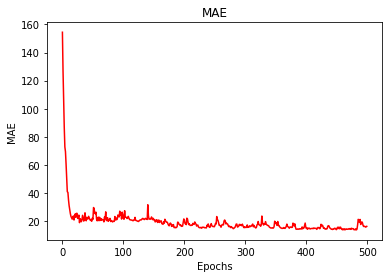

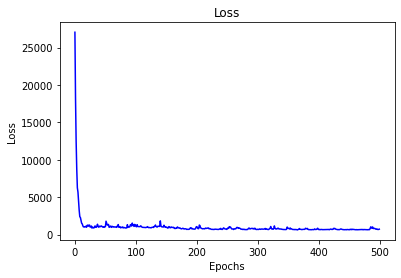

<Figure size 432x288 with 0 Axes>

In [ ]:
#model_best_lr, history_best_lr = run_lstm(dataset_train, tune_lr = False, lr=0.01)
print('best epoch: ', get_best_epoch(history_best_lr))
plot_history(history_best_lr)
np.argmin(np.array(history_best_lr.history['mae']))
history_best_lr.history['mae'][1]

Epoch 1/500
51/51 [==============================] - 21s 418ms/step - loss: 14456.2100 - mae: 106.3663
Epoch 2/500
51/51 [==============================] - 21s 418ms/step - loss: 3114.9880 - mae: 47.4229
Epoch 3/500
51/51 [==============================] - 21s 417ms/step - loss: 2738.6877 - mae: 42.7109
Epoch 4/500
51/51 [==============================] - 21s 417ms/step - loss: 4068.0574 - mae: 51.0333
Epoch 5/500
51/51 [==============================] - 21s 417ms/step - loss: 3385.1045 - mae: 48.2160
Epoch 6/500
51/51 [==============================] - 21s 413ms/step - loss: 3268.8064 - mae: 45.7417
Epoch 7/500
51/51 [==============================] - 21s 416ms/step - loss: 4479.7739 - mae: 46.5523
Epoch 8/500
51/51 [==============================] - 21s 418ms/step - loss: 3519.0884 - mae: 42.3272
Epoch 9/500
51/51 [==============================] - 21s 417ms/step - loss: 3226.2031 - mae: 40.2310
Epoch 10/500
51/51 [==============================] - 21s 417ms/step - loss: 4118.7349 - 

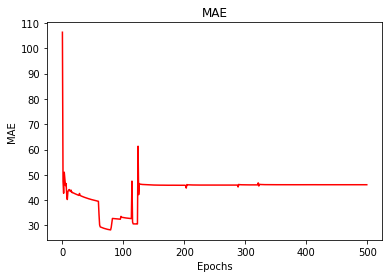

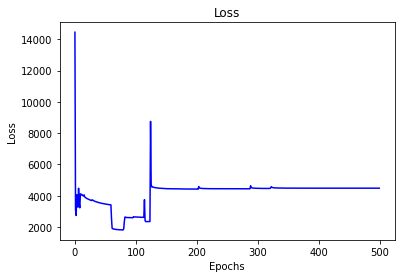

<Figure size 432x288 with 0 Axes>

In [ ]:
#model_best_lr_01, history_best_lr_01 = run_lstm(dataset_train, tune_lr = False, lr=0.1)


In [ ]:
plot_history(history_best_lr_01)
np.argmin(np.array(history_best_lr_01.history['mae']))